### 1. Set Up

In [23]:
import numpy as np
import pandas as pd 
import os

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from wordcloud import WordCloud, STOPWORDS

# Torch and Sklearn
import torch as nn

In [37]:
import warnings
from pylab import rcParams

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED =42
sns.set(style='whitegrid',palette='muted',font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#f0d407','#fbec7e','#04345b','#596e3e','#948304','#2f524f']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [25]:
DATA_PATH = '/content/drive/MyDrive/[P] DisasterTweets/data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')

In [27]:
FIG_PATH = '/content/drive/MyDrive/[P] DisasterTweets/figures'

### 2. Load Data

In [28]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [29]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [30]:
test_df.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [31]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### 3. Text Preprocessing

In [32]:
import re

def text_preprocessing(text):
    text = re.sub(r'(@.*?)[\s]', ' ', text)
    text = re.sub(r'[0-9]+' , '' ,text)
    text = re.sub(r'\s([@][\w_-]+)', '', text).strip()
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.replace("#" , " ")
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [33]:
train_df['text_processed'] = train_df['text'].map(text_preprocessing)

### Step 4: EDA

#### 4.1. WordCloud

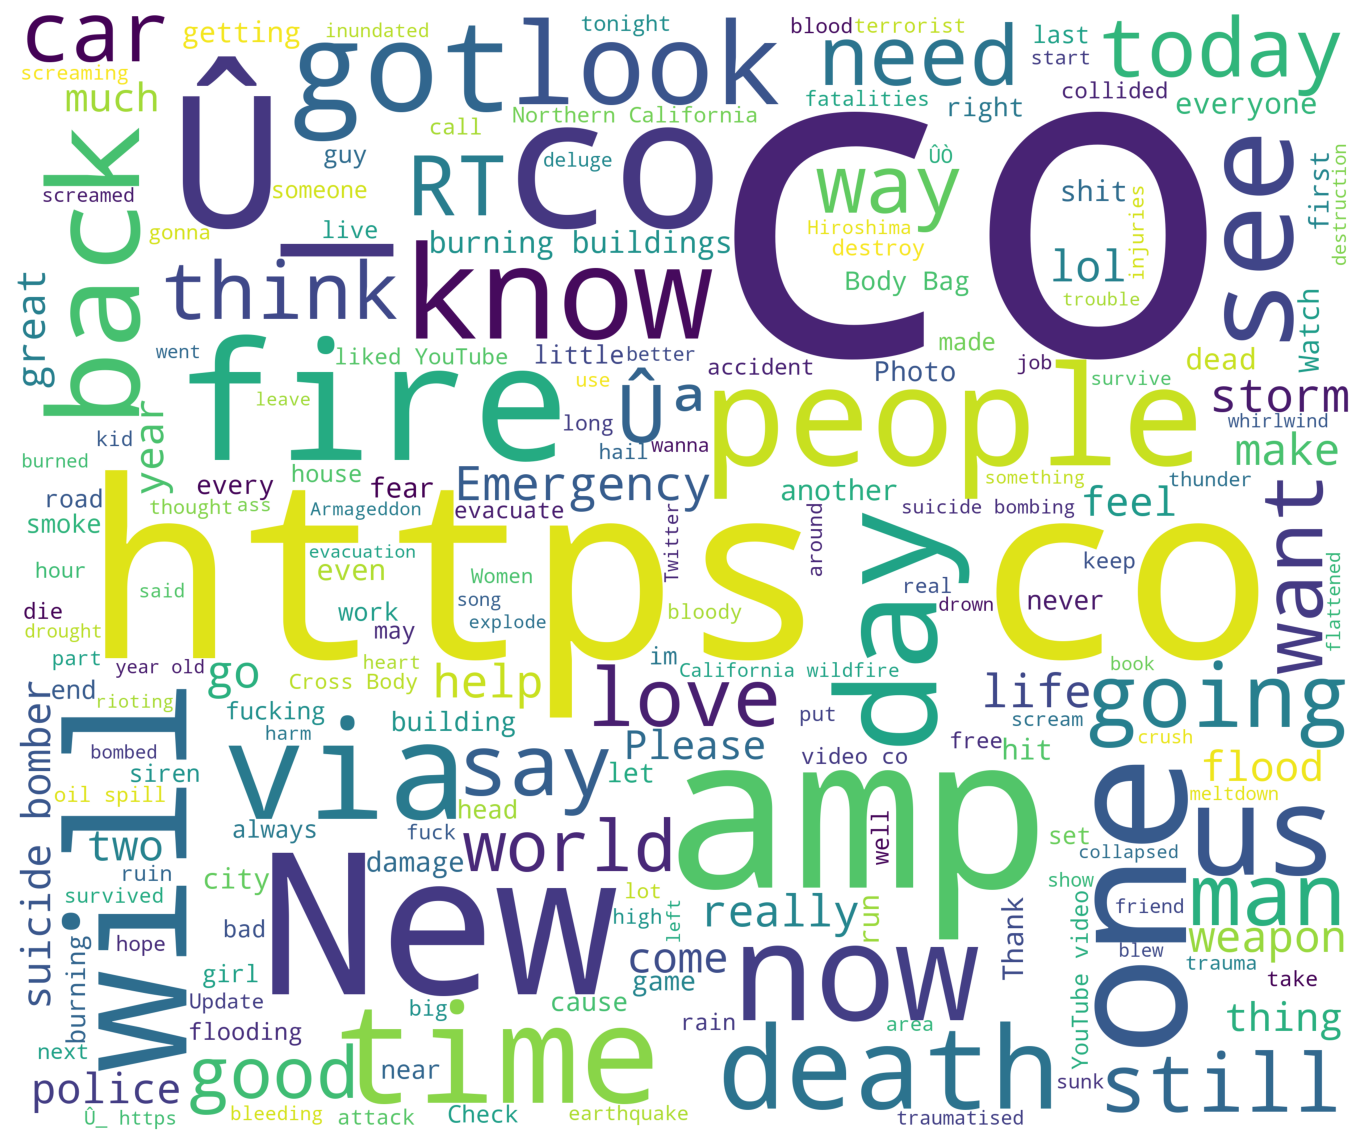

In [34]:
# No preprocessing
common_word_no_preprocess = ' '.join(train_df['text'])

wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    width=3000,
    height=2500
    ).generate(common_word_no_preprocess)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


wordcloud.to_file(os.path.join(FIG_PATH, 'wordcloud_np.png'))

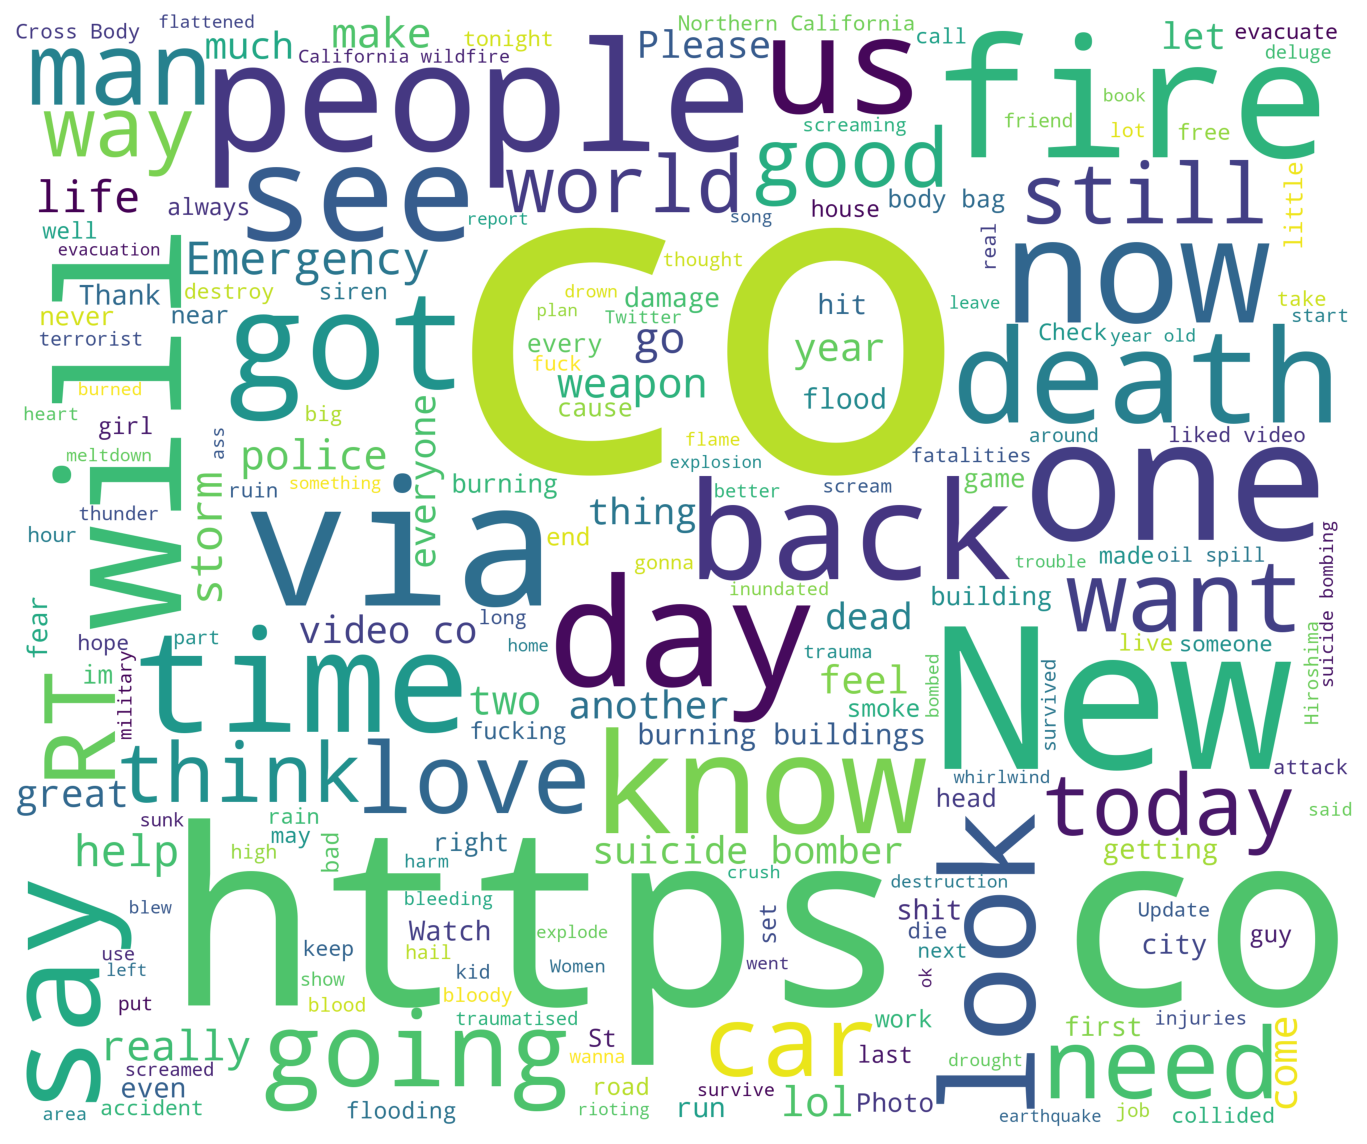

In [35]:
# Preprocessed version
common_word = ' '.join(train_df['text_processed'])

wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    width=3000,
    height=2500
    ).generate(common_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


wordcloud.to_file(os.path.join(FIG_PATH, 'wordcloud.png'))

#### 4.2. Number of Classes

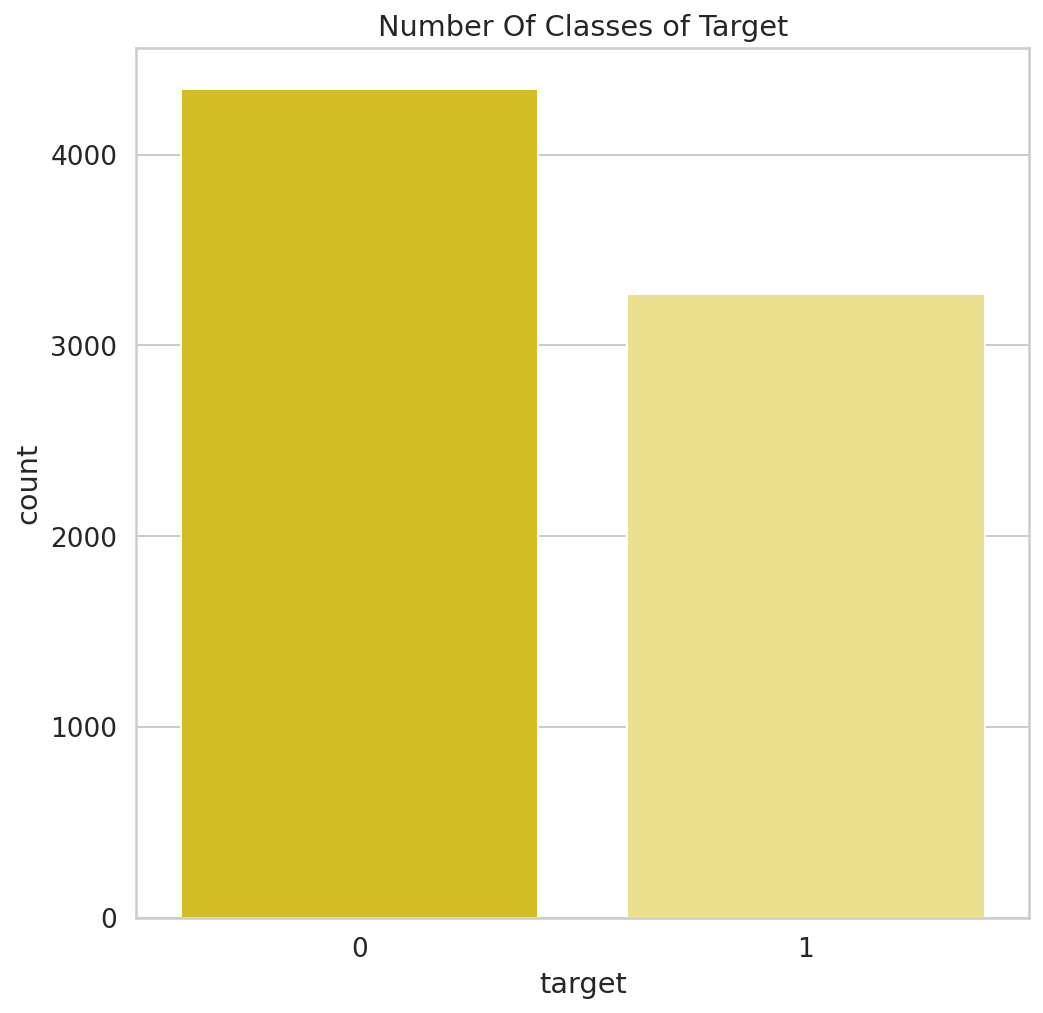

In [38]:
plt.figure(figsize=(8, 8))
count_plot = sns.countplot(x = 'target', data = train_df)
plt.title('Number Of Classes of Target')
count_plot.figure.savefig(os.path.join(FIG_PATH, 'target_class_dist.png'), dpi=300)
plt.show()

#### 4.3. Text Length

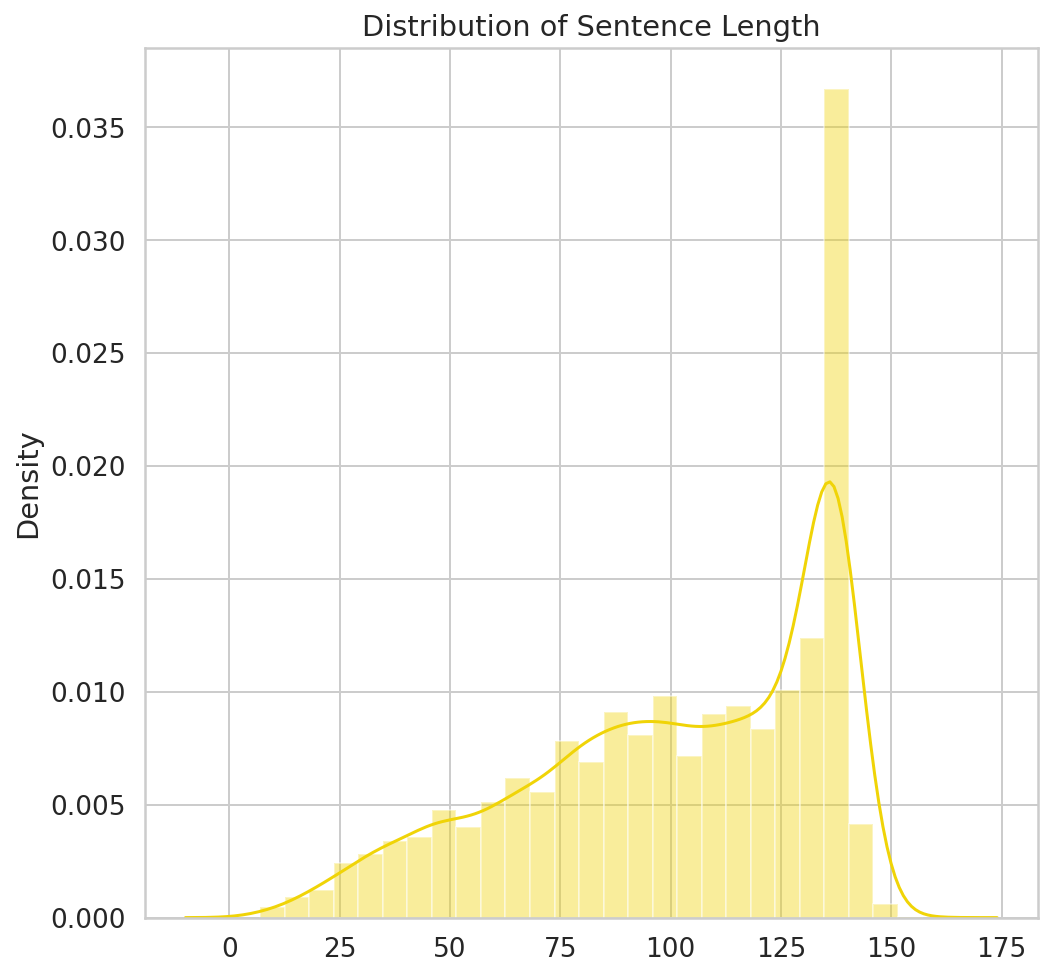

In [39]:
plt.figure(figsize=(8, 8))
length = [len(sent) for sent in train_df.text]
plt.title('Distribution of Sentence Length')
dist_plot = sns.distplot(length)
dist_plot.figure.savefig(os.path.join(FIG_PATH, 'sent_len_dist.png'), dpi=300)
plt.show()

#### 4.4. Quick Attempt at Topic Modelling

In [40]:
import spacy 
from spacy import displacy

nlp = spacy.load('en')
text = ' '.join(train_df['text'])
doc = nlp(text)

In [41]:
texts, article = [], []

for word in doc:
    
    if word.text != '\n' and not word.is_stop and not word.is_punct and not word.like_num and word.text != 'I':
        article.append(word.lemma_)
        
    if word.text == '\n':
        texts.append(article)
        article = []

In [42]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet

bigram = gensim.models.phrases.Phrases(texts)
texts = [bigram[line] for line in texts]

In [43]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

**LSI - Latent Semantic Indexing**

In [44]:
lsi_model = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsi_model.show_topics(num_topics=5)

[(0,
  '0.405*" " + 0.189*"amp" + 0.180*"like" + 0.167*"fire" + 0.161*"burn" + 0.140*"get" + 0.120*"go" + 0.107*"come" + 0.102*"people" + 0.100*"think"'),
 (1,
  '0.290*"hostage" + 0.208*"prebreak_good" + 0.208*"hot_ " + 0.204*"hijack" + 0.182*"datum_sound" + 0.182*"Hellfire" + 0.182*"Funtenna_hijack" + 0.182*"Hijacker" + 0.182*"computer_send" + 0.182*"wave_Black"'),
 (2,
  '-0.456*"burn" + 0.439*"deluge" + -0.268*"fire" + -0.233*"evacuate" + 0.182*"demolish" + -0.165*"burn_building" + 0.124*"Debris" + 0.114*"MH370" + 0.106*"debris" + 0.105*"debris_find"'),
 (3,
  '-0.418*"burn" + -0.411*"deluge" + -0.168*"demolish" + -0.157*"fire" + -0.153*"burn_building" + 0.125*"injury" + -0.119*"evacuate" + -0.116*"Debris" + -0.102*"MH370" + -0.098*"debris_find"'),
 (4,
  '-0.745*"evacuate" + 0.341*"burn" + -0.145*"fire" + 0.141*"burn_building" + -0.100*"fire_alarm" + 0.093*"crush" + -0.075*"cinema" + -0.074*"passenger" + -0.074*"angry" + 0.069*"like"')]

**HDP - Hierarchical Drichlet Process**

In [45]:
hdp_model = HdpModel(corpus=corpus, id2word=dictionary)
hdp_model.show_topics()

[(0,
  '0.006*traumatise + 0.005*  + 0.005*trouble + 0.004*wreck + 0.003*like + 0.003*watch + 0.003*confirm_mh370 + 0.003*amp + 0.003*Malaysia_pm + 0.002*go + 0.002*investigator_family + 0.002*get + 0.002*people + 0.002*trauma + 0.002*upheaval + 0.002*storm + 0.002*violent + 0.002*wreckage + 0.002*destroy + 0.002*look'),
 (1,
  '0.005*twister + 0.005*  + 0.004*wild_fire + 0.004*Typhoon_Soudelor + 0.003*devastate_Saipan + 0.003*Obama_declare + 0.003*Disaster_Typhoon + 0.003*evacuate + 0.003*amp + 0.003*Twister + 0.003*Obama_sign + 0.003*whirlwind + 0.003*disaster_declaration + 0.003*California + 0.002*like + 0.002*Taiwan + 0.002*deluge + 0.002*Northern_Marians + 0.002*tsunami + 0.002*panic'),
 (2,
  '0.005*windstorm + 0.004*Wildfire + 0.003*wildfire + 0.003*fire + 0.003*  + 0.003*Windstorm + 0.003*Texas_seek + 0.002*Comment_rule + 0.002*like + 0.002*change_Windstorm + 0.002*California + 0.002*kill + 0.002*Insurer + 0.002*Parker + 0.002*wound + 0.002*drown + 0.002*fall + 0.001*Ridge + 0.

**LDA - Latent Dirchlet Allocation**

In [46]:
lda_model = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)
lda_model.show_topics()

[(0,
  '0.006*" " + 0.004*"amp" + 0.004*"like" + 0.003*"crush" + 0.002*"drown" + 0.002*"come" + 0.002*"go" + 0.002*"know" + 0.002*"scream" + 0.002*"want"'),
 (1,
  '0.006*" " + 0.003*"like" + 0.003*"amp" + 0.002*"get" + 0.002*"crash" + 0.002*"weapon" + 0.002*"kill" + 0.002*"come" + 0.002*"say" + 0.002*"fire"'),
 (2,
  '0.007*" " + 0.004*"amp" + 0.003*"scream" + 0.003*"death" + 0.003*"like" + 0.002*"survive" + 0.002*"fatality" + 0.002*"|" + 0.002*"electrocute" + 0.002*"love"'),
 (3,
  '0.005*" " + 0.003*"burn" + 0.003*"amp" + 0.003*"like" + 0.002*"fire" + 0.002*"video" + 0.002*"sink" + 0.002*"\n\n" + 0.002*"day" + 0.002*"burn_building"'),
 (4,
  '0.006*" " + 0.004*"blow" + 0.003*"amp" + 0.003*"like" + 0.003*"go" + 0.003*"get" + 0.002*"explode" + 0.002*"know" + 0.002*"think" + 0.002*"come"'),
 (5,
  '0.004*" " + 0.003*"bomb" + 0.002*"amp" + 0.002*"crash" + 0.002*"get" + 0.002*"burn" + 0.002*"lightning" + 0.002*"like" + 0.002*"mass_murderer" + 0.002*"come"'),
 (6,
  '0.007*" " + 0.003*"li

**pyLDAvis**

In [55]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7MB 8.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 9.9MB 29.8MB/s 
     |████████████████████████████████| 15.3MB 398kB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-cp37-none-any.whl size=136897 sha256=91e24ae18c8271b10d9cb3cf9b019a91b29af75c2db11943ab772ecb772ecbe2
  Stored in directory: /root/.cache/pip/wheels/a0/9c/fc/c6e00689d35c82cf96a8adc70edfe7ba7904374fdac3240ac2
Successfully built pyLDAvis
ERROR: tensorflow 2.5.0 has requirement numpy~=1.19.2, but you'll have numpy 1.20.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.1.0; python_version >= "3.0", but you'll have pandas 1.2.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0

In [47]:
import pyLDAvis.gensim_models

In [48]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.039011 -0.001747       1        1  15.268877
0      0.010005 -0.000786       2        1  12.396665
2     -0.012155  0.008137       3        1  11.906315
6     -0.011231 -0.015527       4        1  11.407681
9      0.006983 -0.002857       5        1  10.590097
1     -0.003375 -0.005128       6        1  10.282870
4      0.020590  0.026591       7        1   7.621447
8     -0.006764  0.014930       8        1   7.582850
5      0.020803 -0.036917       9        1   6.647427
3      0.014156  0.013303      10        1   6.295770, topic_info=         Term       Freq       Total Category  logprob  loglift
3483     blow  55.000000   55.000000  Default  30.0000  30.0000
650    scream  70.000000   70.000000  Default  29.0000  29.0000
5261  explode  48.000000   48.000000  Default  28.0000  28.0000
4537     bomb  67.000000   67.000000  Default  27.0000  27.0000
194      burn  81.000000   81.000000  Default  26.0000  26.0000
...       ...        ...         ...      ...      ...      ...
233      year   4.689772   79.946406  Topic10  -6.7868  -0.0707
109       get   5.245684  138.944539  Topic10  -6.6748  -0.5114
1098    think   4.663090   96.208834  Topic10  -6.7925  -0.2616
618      good   4.577556   84.775977  Topic10  -6.8110  -0.1536
229      want   4.583375   87.894982  Topic10  -6.8098  -0.1884

[836 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
234        1  0.199388         \n\n
234        2  0.121367         \n\n
234        3  0.121367         \n\n
234        4  0.182050         \n\n
234        5  0.086690         \n\n
...      ...       ...          ...
21478      5  0.108014  ÛÏWhen_see
21478      6  0.108014  ÛÏWhen_see
21478      9  0.216027  ÛÏWhen_see
1181       8  0.689300   Û÷ALLOOSH
13241     10  0.764964      ûókody

[2259 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 3, 7, 10, 2, 5, 9, 6, 4])